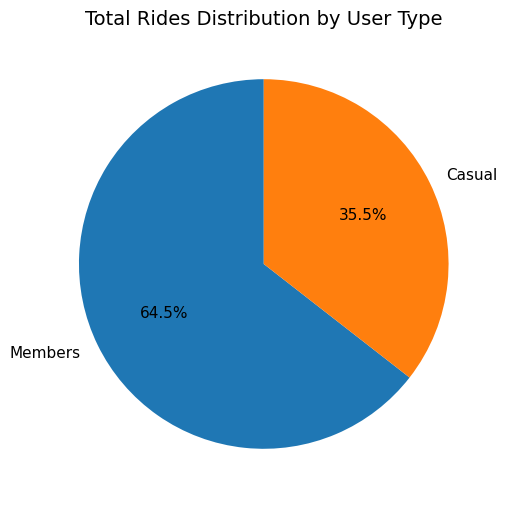

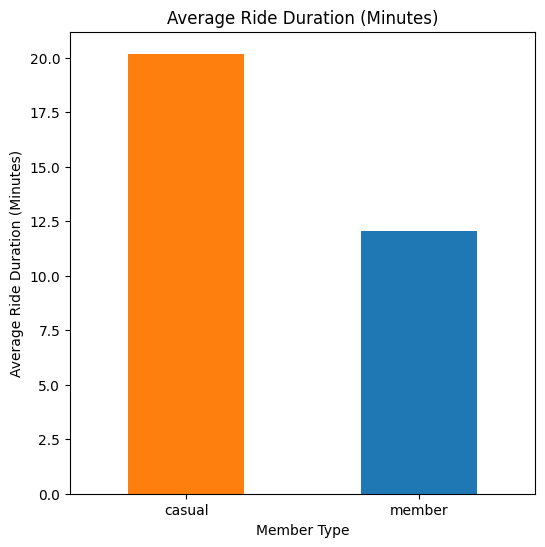

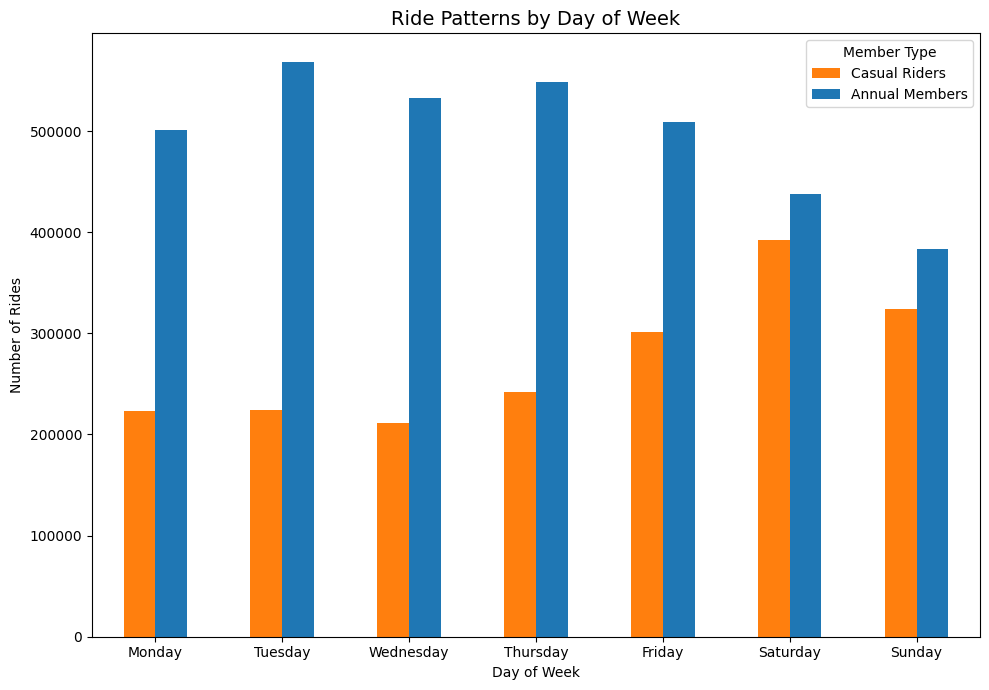

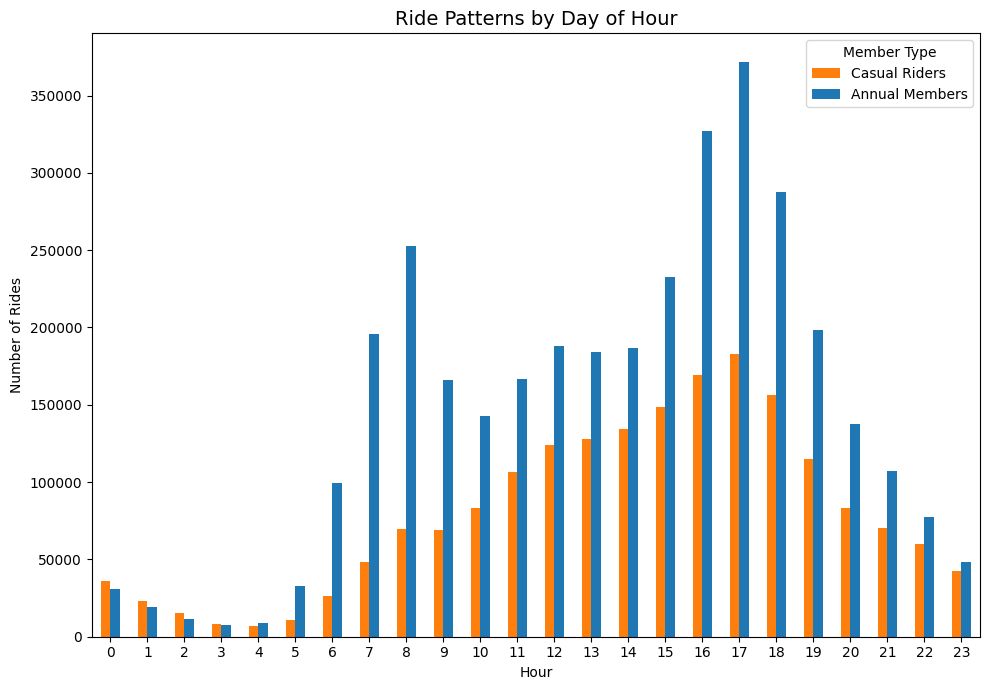

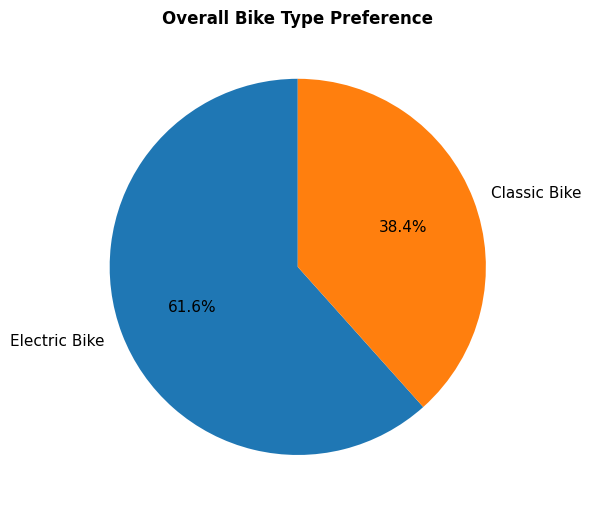

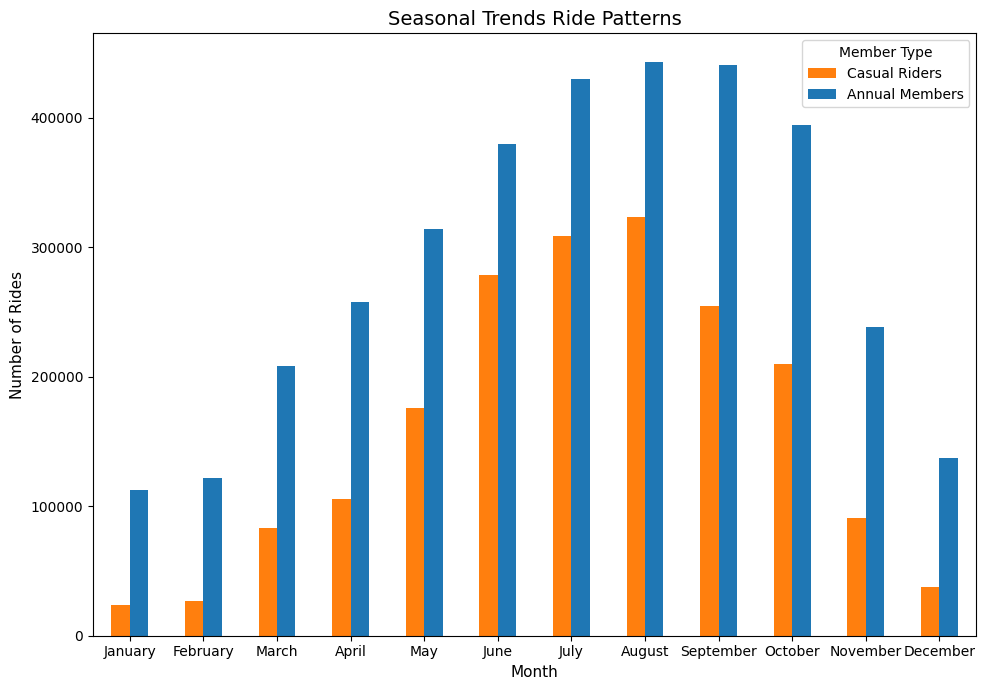

In [30]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os


data_path = '../data'
# Load all the data and  print  total  files
all_files = glob.glob(os.path.join(data_path, '*.csv'))
#print(f" Number of loaded files: {len(all_files)}")

# Append all data in files  to a single  list
df_list = []
for file in all_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

#  Get number  of rows and  columns
df = pd.concat(df_list, ignore_index=True)

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

df['ride_duration_mins'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60


# Exclude rides shorter than 1 minute and longer than 24 hours
validTrips = (df['ride_duration_mins'] > 1) & (df['ride_duration_mins'] < 1440)
df_filtered = df[validTrips]

# Adding 3 new rows day_of_week, month, hour
df_filtered = df_filtered.copy()
df_filtered['day_of_week'] = df_filtered['started_at'].dt.day_name()
df_filtered['month']       = df_filtered['started_at'].dt.month_name()
df_filtered['hour']        = df_filtered['started_at'].dt.hour

# ordering the days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_filtered['day_of_week'] = pd.Categorical(df_filtered['day_of_week'], categories=day_order, ordered=True)

# ordering the months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df_filtered['month'] = pd.Categorical(df_filtered['month'], categories=month_order, ordered=True)

#-----------------
# Total Rides by User Type
#-----------------
# Total Rides by User Type : casual
casual_count = len(df_filtered[df_filtered['member_casual'] == 'casual'])

# Total Rides by User Type : member
member_count = len(df_filtered[df_filtered['member_casual'] == 'member'])

#-----------------
# Average Ride Duration
#-----------------
#  Avg trip duration
avg_duration_mins = df_filtered['ride_duration_mins'].mean()
#print(f"Average duration mins : {avg_duration_mins:,}")

#  Avg trip duration by member type
mean_duration = df_filtered.groupby('member_casual')['ride_duration_mins'].mean()

#-----------------
#Ride Patterns by Day of Week
#-----------------
filter_annual = df_filtered[df_filtered['member_casual'].isin(['member'])]
annual_day_counts = filter_annual['day_of_week'].value_counts()

annual_summary = pd.DataFrame({
    'Rides Count': annual_day_counts,
    'Percentage (%)': (annual_day_counts / member_count * 100).round(2)
})

filter_casual = df_filtered[df_filtered['member_casual'].isin(['casual'])]
casual_day_counts = filter_casual['day_of_week'].value_counts()

casual_summary = pd.DataFrame({
    'Rides Count': casual_day_counts,
    'Percentage (%)': (casual_day_counts / casual_count * 100).round(2)
})

#-----------------
# Ride Patterns by Hour
#-----------------
annual_hour_counts = filter_annual['hour'].value_counts().sort_index()
annual_hour_summary = pd.DataFrame({
    'Rides Count': annual_hour_counts,
    'Percentage (%)': (annual_hour_counts / member_count * 100).round(2)
})

casual_hour_counts = filter_casual['hour'].value_counts().sort_index()
casual_hour_summary = pd.DataFrame({
    'Rides Count': casual_hour_counts,
    'Percentage (%)': (casual_hour_counts / casual_count * 100).round(2)
})

#-----------------
#  Bike Type Preference
#-----------------
annual_bike_type = filter_annual['rideable_type'].value_counts().sort_index()
annual_bike_type_summary = pd.DataFrame({
    'Rides Count': annual_bike_type,
    'Percentage (%)': (annual_bike_type / member_count * 100).round(2)
})

casual_bike_type = filter_casual['rideable_type'].value_counts().sort_index()
casual_bike_type_summary = pd.DataFrame({
    'Rides Count': casual_bike_type,
    'Percentage (%)': (casual_bike_type / casual_count * 100).round(2)
})

#-----------------
# Seasonal Trends
#-----------------
annual_bike_seasonal = filter_annual['month'].value_counts().sort_index()
annual_bike_seasonal_summary = pd.DataFrame({
    'Rides Count': annual_bike_seasonal,
    'Percentage (%)': (annual_bike_seasonal / member_count * 100).round(2)
})


casual_bike_seasonal = filter_casual['month'].value_counts().sort_index()
casual_bike_seasonal_summary = pd.DataFrame({
    'Rides Count': casual_bike_seasonal,
    'Percentage (%)': (casual_bike_seasonal / casual_count * 100).round(2)
})

#-------------

# -- Plotting --

#-------------
# Total Rides by User Type
#-------------
plt.figure(figsize=(6, 6))
plt.pie(
    [member_count, casual_count],
    labels=['Members', 'Casual'],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 11}
)
plt.title('Total Rides Distribution by User Type', fontsize=14)
#plt.show()

#-----------------
# Average Ride Duration
#-----------------
plt.figure(figsize=(6, 6))
mean_duration.plot(kind='bar', color=['tab:orange', 'tab:blue'])
plt.title('Average Ride Duration (Minutes)')
plt.xticks(rotation=0)
plt.ylabel('Average Ride Duration (Minutes)')
plt.xlabel('Member Type')
plt.show()

#-----------------
#Ride Patterns by Day of Week
#-----------------
df_filtered.groupby(['day_of_week', 'member_casual'], observed=True).size().unstack().plot(
kind='bar', figsize=(10,7), color=['tab:orange', 'tab:blue'])

plt.title('Ride Patterns by Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.legend(['Casual Riders', 'Annual Members'], title='Member Type')
plt.xticks(rotation=0)
plt.tight_layout()

#-----------------
# Ride Patterns by Hour
#-----------------
df_filtered.groupby(['hour', 'member_casual'], observed=True).size().unstack().plot(
kind='bar', figsize=(10,7), color=['tab:orange', 'tab:blue'])

plt.title('Ride Patterns by Day of Hour', fontsize=14)
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.legend(['Casual Riders', 'Annual Members'], title='Member Type')
plt.xticks(rotation=0)
plt.tight_layout()

#-----------------
# Bike Type Preference
#-----------------
plt.figure(figsize=(6,6))
df_filtered['rideable_type'].value_counts().plot(
    labels=['Electric Bike', 'Classic Bike'],
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 11})

plt.title('Overall Bike Type Preference')
plt.ylabel('')
plt.tight_layout()
plt.show()

#-----------------
# Seasonal Trends
#-----------------
df_filtered.groupby(['month', 'member_casual'], observed=True).size().unstack().plot(
kind='bar', figsize=(10,7), color=['tab:orange', 'tab:blue'])

plt.title('Seasonal Trends Ride Patterns', fontsize=14)
plt.xlabel('Month', fontsize=11)
plt.ylabel('Number of Rides', fontsize=11)
plt.legend(['Casual Riders', 'Annual Members'], title='Member Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


